In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import scipy.optimize   #for log-likelihood
from scipy.special import iv  #for Bessel function
from scipy.stats import vonmises  #for von Mises distribution

%matplotlib inline

In [296]:
#incoporate the temporal kernel for chemo-sensing
def temporal_kernel(alpha,tau):
    """
    biphasic temporal kernel
    tau is the temporal domain and alpha controls the form
    """
    D_tau = alpha*np.exp(-alpha*tau)*((alpha*tau)**5/math.factorial(5) - (alpha*tau)**7/math.factorial(7))
    return D_tau

#check with auto-correlation in time series
def autocorr(x):
    """
    Autocorrelation function for time-series
    """
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

#Hybrid Gaussian process for angle time series
def d_theta(alpha, dc_perp, K, w, dC, T):
    '''
    Return change in theta angle for each step
    Input with K_dcp for kernel, dc for orthogonal concentration difference, and K covariance in weathervaning
    K_dc as the weighting/kernel on concentration in the signoidal function for tumbling rate 
    '''
    wv = alpha*dc_perp + K*np.random.randn()  #weathervaning strategy
    #P_event = 0.023/(0.4 + np.exp(40*dC/dt)) + 0.003  #sigmoidal function with parameters w
    St = dC-T #max(T-dC,0)  #ACT model
#     if T>=conv:
#         P_event = 0.15  #threshold crossing events
#     elif T<conv:
#         P_event = 0.003  #spontaneous turning
    P_event = 1*0.023/(0.4 + np.exp(1*St)) + 0.003
    if np.random.rand() < P_event:
        beta = 1
    else:
        beta = 0
    rt = beta*(np.random.rand()*360-180) #(2*np.pi)  #run-and-tumble strategy
    dth = wv + rt
    if dth > 180:
        dth = dth-360  #bounded by angle measurements
    if dth < -180:
        dth = dth+360
    return dth

def ACT(C,K,tau,T):
    """
    Threshold dynamics in the adaptive concentration threshold model
    """
    T_ = T + dt*(-1/tau*T + K*(1-np.exp(-(C/K)))/tau)  #threshold dynamics
    return T_
    

#concentration gradient in space
def gradient(C0,x,y):
    """
    Gaussian sptatial profile through diffision equation
    """
    concentration = C0/(4*np.pi*d*D*duT)*np.exp(-(x-dis2targ)**2/(400*D*duT*50))  #depends on diffusion conditions along x-axis
    return concentration

#measure for concentration difference for weathervane
def dc_measure(dxy,xx,yy):
    """
    perpendicular concentration measure
    """
    perp_dir = np.array([-dxy[1], dxy[0]])  #perpdendicular direction
    perp_dir = perp_dir/np.linalg.norm(perp_dir)*1 #unit norm vector
    perp_dC = gradient(C0, xx+perp_dir[0], yy+perp_dir[1]) - gradient(C0, xx-perp_dir[0], yy-perp_dir[1])
    return perp_dC


In [303]:
# %%
#gradient environment
dis2targ = 50
C0 = 2  #initial concentration
D = 0.000015  #diffusion coefficient (for a reasonable simulation environment)
duT = 60*60*3  #equilibrium time
d = 0.18*1  #difussion coefficient of butanone...

In [304]:
#chemotaxis strategy parameter
alpha = 10  #strength of OU forcing
K = 5  #covariance of weathervane
w = 0  #logistic parameter (default for now)
TT = 3000  #time course of simulation
dt = 0.6  #seconds
v_m = 0.12*1.  #mm/s
v_s = 0.01  #std of speed

#ACT parameters
K_ = 5.5  #uM kinetics of threshold moving
tau = 15  #slow time scale

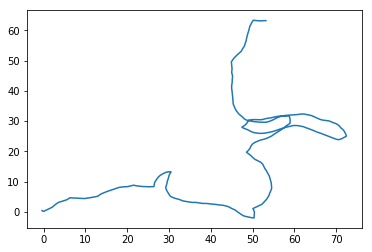

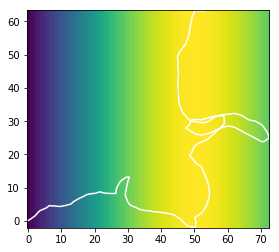

In [305]:
time = np.arange(0,TT*dt,dt)
xs = np.zeros(time.shape)
ys = np.zeros(time.shape)  #2D location
xs[0] = np.random.randn()
ys[0] = np.random.randn()
ths = np.zeros(time.shape)  #angles
ths[0] = np.random.randn()
dths = np.zeros(time.shape)
Ts = np.zeros(time.shape)  #adaptive concentration threshold
Ts[0] = 0
dcs = np.zeros(time.shape)  #record all concentrations
dcps = np.zeros(time.shape)  #record all perpendicular concentrations
dxy = np.random.randn(2)

### with turning (Brownian-like tragectories)
for t in range(1,len(time)):
   
    dC = gradient(C0, xs[t-1],ys[t-1])
    dc_perp = dc_measure(dxy,xs[t-1],ys[t-1])      
    Ts[t] = ACT(dC,K_,tau,Ts[t-1])   #adaptive threshold
    dth = d_theta(alpha, -dc_perp, K, 0, dC, Ts[t])
    ths[t] = ths[t-1] + dth*dt

    dcs[t] = dC  #concentration
    dcps[t] = dc_perp  #perpendicular concentration difference
    dths[t] = dth  #heading angles 
    
    e1 = np.array([1,0])
    vec = np.array([xs[t-1],ys[t-1]])
    theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)

    vv = v_m + v_s*np.random.randn()
    dd = np.array([vv*np.sin(ths[t]*np.pi/180), vv*np.cos(ths[t]*np.pi/180)])  #displacement
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
    dxy = np.dot(R,dd)

    xs[t] = xs[t-1] + dxy[0]*dt
    ys[t] = ys[t-1] + dxy[1]*dt

#plt.plot(ths)
plt.figure()
plt.plot(xs,ys)
plt.figure()
x = np.arange(np.min(xs),np.max(xs),1)
xx_grad = C0/(4*np.pi*d*D*duT)*np.exp(-(x-dis2targ)**2/(400*D*duT*50))
plt.imshow(np.expand_dims(xx_grad,axis=1).T,extent=[np.min(xs),np.max(xs),np.min(ys),np.max(ys)])
plt.plot(xs,ys,'white')

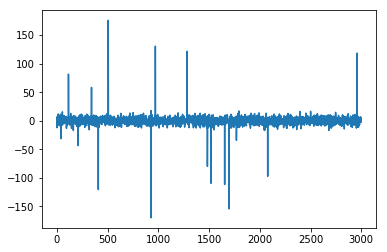

In [306]:
plt.plot(dths)

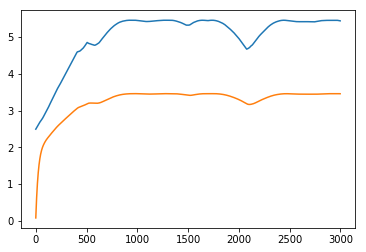

In [307]:
plt.plot(dcs[1:])
plt.plot(Ts[1:])

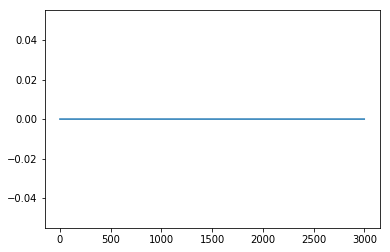

In [308]:
plt.plot(np.maximum(np.zeros(len(Ts)),Ts-dcs))